In [7]:
# Data Manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Natural Language Processing
import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
#Loading the data from a csv file
data = pd.read_csv("/content/drive/MyDrive/comments_1st.csv", encoding="ISO-8859-1")
comment_column = data.filter(['comments'])

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment score for each comment
def get_sentiment_score(comment):
    return sid.polarity_scores(comment)['compound']

# Add a new column 'score' with sentiment scores
comment_column['score'] = comment_column['comments'].apply(get_sentiment_score)

In [9]:
# Function to map score to sentiment label
def map_score_to_sentiment(score):
    if score > 0.5:
        return 'positive'
    elif score < 0.0:
        return 'negative'
    else:
        return 'neutral'

# Add a new column 'sentiment' with sentiment labels
comment_column['sentiment'] = comment_column['score'].apply(map_score_to_sentiment)
comment_column.head(5)


,comments,score,sentiment
0,Meeting Marsha Collier in person = priceless! ...,0.7333,positive
1,I figured you'd be working anyway. Thanks so m...,0.4404,neutral
2,Do you have the ability to get a full length f...,0.3182,neutral
3,Bummed I am just seeing this! Hope you had a f...,0.8105,positive
4,This is soooo awesome! Wish i could join you a...,0.9493,positive


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

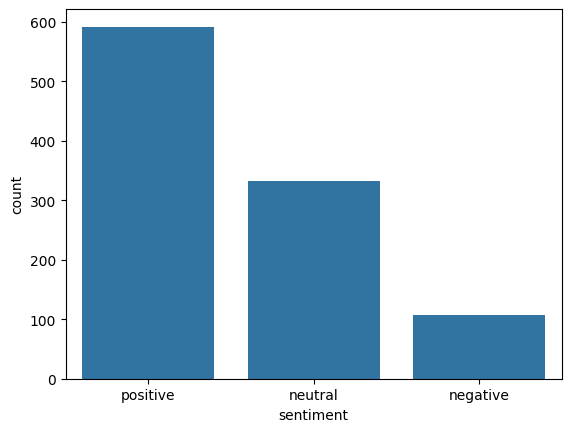

In [10]:
# Plotting the data
sns.countplot(x='sentiment', data=comment_column)
plt.title

In [11]:
# Conveting our target column "Sentiment" into numerical format. Positve to 2 , Neutral to 1 and negative to 0
comment_column.sentiment.replace("positive", 2, inplace=True)
comment_column.sentiment.replace("neutral", 1, inplace=True)
comment_column.sentiment.replace("negative", 0, inplace=True)
comment_column.head(5)

,comments,score,sentiment
0,Meeting Marsha Collier in person = priceless! ...,0.7333,2
1,I figured you'd be working anyway. Thanks so m...,0.4404,1
2,Do you have the ability to get a full length f...,0.3182,1
3,Bummed I am just seeing this! Hope you had a f...,0.8105,2
4,This is soooo awesome! Wish i could join you a...,0.9493,2


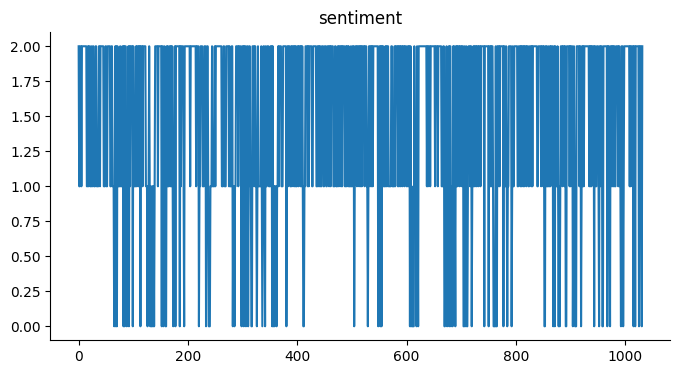

In [12]:
# @title sentiment

from matplotlib import pyplot as plt
comment_column['sentiment'].plot(kind='line', figsize=(8, 4), title='sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

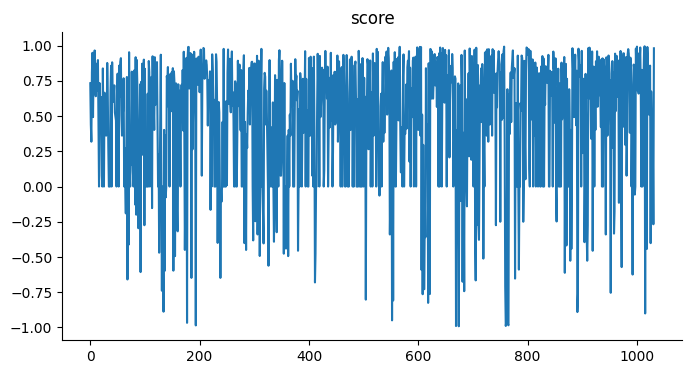

In [13]:
# @title score

from matplotlib import pyplot as plt
comment_column['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
# Text Preprocessing

def preprocess_text(text):
    """
    Preprocesses a given text by:
    1. Removing URLs
    2. Removing HTML tags
    3. Removing noise texts
    4. Converting text to lowercase
    5. Removing punctuation
    6. Removing numbers
    7. Tokenization
    8. Removing stopwords
    9. Stemming
    """
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove noise texts (you can customize this based on your data)
    noise_list = ['@username', 'RT', '&amp;', '...', 'etc.']
    for noise in noise_list:
        text = text.replace(noise, '')

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Join the stemmed tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)

    # Ensure the preprocessed text contains only alphabetic characters
    preprocessed_text = re.sub(r'[^a-zA-Z\s]', '', preprocessed_text)

    return preprocessed_text.strip()  # Remove leading and trailing whitespaces

# Preprocess the comments
comment_column['preprocessed_comments'] = comment_column['comments'].apply(preprocess_text)
comment_column.head(5)

,comments,score,sentiment,preprocessed_comments
0,Meeting Marsha Collier in person = priceless! ...,0.7333,2,meet marsha collier person priceless excit att...
1,I figured you'd be working anyway. Thanks so m...,0.4404,1,figur youd work anyway thank much mel
2,Do you have the ability to get a full length f...,0.3182,1,abil get full length featur film fund
3,Bummed I am just seeing this! Hope you had a f...,0.8105,2,bum see hope fabul time
4,This is soooo awesome! Wish i could join you a...,0.9493,2,soooo awesom wish could join awesom ladi fun


In [15]:
# Convert preprocessed comments to TF-IDF representation
# Initialize TfidfVectorizer to create TF-IDF representation
vectorizer = CountVectorizer()

# Fit and transform the preprocessed comments to create TF-IDF representation
tfidf_representation = vectorizer.fit_transform(comment_column['preprocessed_comments'])


In [16]:
# Defining input and target variable
X = vectorizer.fit_transform(comment_column['preprocessed_comments'])
y = comment_column['sentiment']

# Splitting the data into training and testing data set
test_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [ ]:
# Initialize the logistic regression classifier
#classifier = RandomForestClassifier(**best_params)
classifier = XGBClassifier(objective='multi:softmax')

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)


[[  3  12   6]
 [  0  44  15]
 [  5  16 106]]


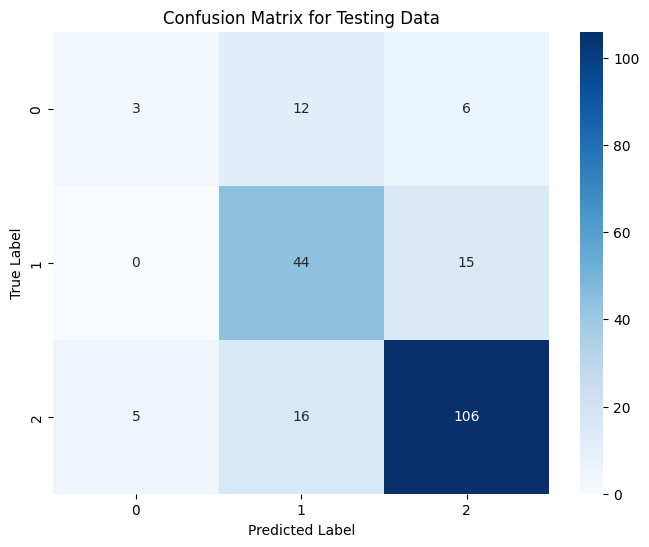

In [20]:
# Calculate confusion matrix for testing data
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Testing Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
